In [1]:
from pocket_cube.cube import Cube
from pocket_cube.cube import Move

%matplotlib notebook

# Creating a scrambled cube 

In [2]:
cube = Cube("F' R U R U F' U'")

## 2D Cube visualization 

<IPython.core.display.Javascript object>


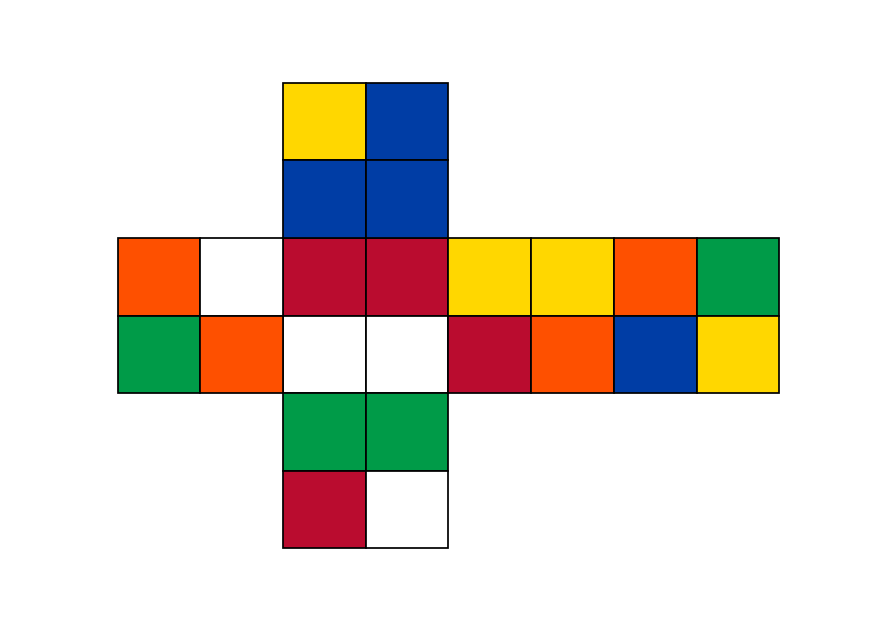

In [3]:
cube.render()

## Text representation 

In [4]:
cube.render_text()

  YB
  BB
OWRRYYOG
GOWWROBY
  GG
  RW


## 3D Cube visualization

For an interactive view of the cube, don't forget to use `%matplotlib notebook`

<IPython.core.display.Javascript object>


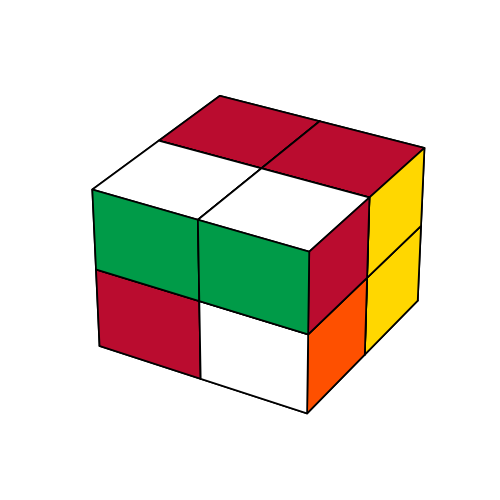

In [5]:
cube.render3D()

# Creating an unscrambled cube 

In [6]:
cube = Cube(scrambled=False)

<IPython.core.display.Javascript object>


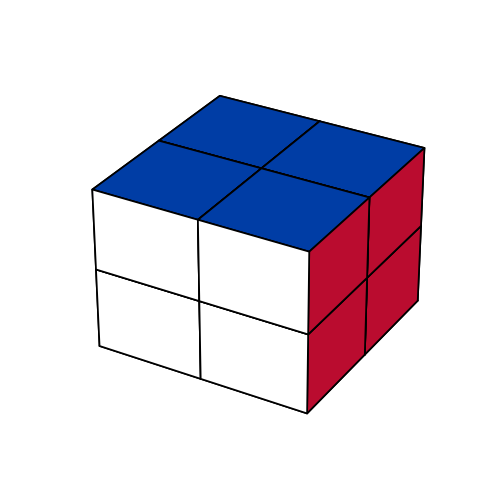

In [7]:
cube.render3D()

## Applying moves on the cube 

In [8]:
cube = cube.move(Move.R)
cube = cube.move(Move.F)

<IPython.core.display.Javascript object>


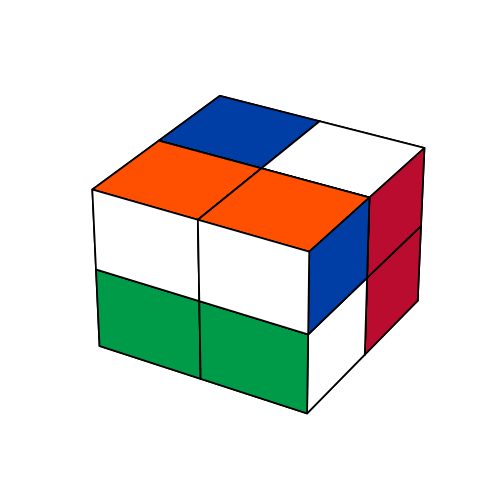

In [9]:
cube.render3D()

<IPython.core.display.Javascript object>


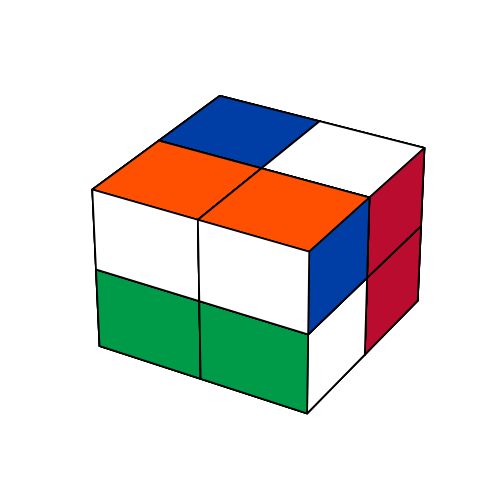

In [10]:
cube.render3D_moves(cube.state, [Move.Fp, Move.Rp])